<a href="https://colab.research.google.com/github/123ranika/jsfinal/blob/main/FacebookAI_xlm_roberta_base_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [7]:
!pip install transformers

## Importing necessary packages

In [8]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [9]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [11]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_excel('/content/Dataset (3).xlsx')


In [12]:
data=data[:4000]

In [13]:
data.count()

,0
texts,4000
labels,4000


In [14]:
data.head()

,texts,labels
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [15]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [16]:
data.head()

,texts,labels,PID
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,1
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,2
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,3
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred,4
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,5


In [17]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="label", new_name="labels")
data = change_column_name(data, old_name="Comments", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,texts,labels
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [18]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'texts', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 4,000

       PID                                              texts  \
555    556                         এখানে দেখছি সব শুওরের মেলা   
3491  3492                        কান দিয়ে ৱক্ত বেৱিয়ে আসবে   
527    528                                 পেন্টি দেখে ফেলেছি   
3925  3926   পিও যখন আয়না ঘরে নিবে তোমাকে তখন বুঝবে কেমন লাগে   
2989  2990                       মাঠে আসলেই দেখা যাবে সে কেমন   
70      71                 পাপিষ্ঠ,পাপিষ্ঠ,আল্লাহ ক্ষমা করুক।   
1756  1757                             ধাক্কা ধাক্কি করবেন না   
211    212  নির্লজ্জ একজন প্রেসিডেন্ট তার লোভের কারণে বাংল...   
196    197                               জোতাইলে ঠিকই করা যেত   
803    804        খালি বিছানার চেয়ে একটা দুষ্টু বউ থাকা ভালো   

                labels  
555      Cyberbullying  
3491           Sarcasm  
527      Cyberbullying  
3925         Political  
2989           Sarcasm  
70    Religious_Hatred  
1756     Cyberbullying  
211      Cyberbullying  
196      Cyberbullying

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [20]:
train_df

,PID,texts,labels
3994,3995,আওয়ামী লীগ ক্ষমতায় না আসা অব্দি এরা এই পোস্টই ...,Political
423,424,সালা বাটপার নাকি এমন কেন ভাই,Cyberbullying
2991,2992,মেয়াদ কত দিন,Sarcasm
1221,1222,এখন তাকে নটিপারা ভর্তি করে দেওয়া হোক,Cyberbullying
506,507,আস্তাগফিরুল্লাহ নাউজুবিল্লাহ এই টা আমি না,Religious_Hatred
...,...,...,...
1130,1131,ওরা টাকার জন্য সব কিছু করতে পারবে,Cyberbullying
1294,1295,জঙ্গলে গিয়া বাস করি! উফফ ডিসকাসটিং।,Cyberbullying
860,861,অতি টিপার ফল,Cyberbullying
3507,3508,ওমা দেখি গাছটার ডালাটা ভেঙ্গে গেল,Sarcasm


In [21]:
test_df

,PID,texts,labels
1987,1988,খেলা দুলা করার মতো কেউ নেই,Sarcasm
2893,2894,সেফুদার শিষ্য মনে হচ্ছে,Sarcasm
1860,1861,সালাদের মাথার চুল হুদাই পাকছে,Cyberbullying
3829,3830,সব কথা বের হচ্ছে,Sarcasm
240,241,"ওনার কোনো লজ্জা নেই, ওনি ওনার পদ ছাড়বে না, যতো...",Political
...,...,...,...
3238,3239,কাউয়া কা কা ছাড়া পারে কি,Sarcasm
33,34,অবৈধ স্বৈরাচার সরকারের বিরুদ্ধে আন্দোলন গড়ে ত...,Political
486,487,আমি ত বউ এর মাথা খুজে পাচ্ছিলাম না,Sarcasm
69,70,"গান গায় জেফার,,,শ্বাসকষ্ট হয় আমাদের.",Sarcasm


In [22]:
val_df

,PID,texts,labels
2335,2336,ভুসকি রেপ্লাই দিলি কেনো যদি প্রেম না করবি,Cyberbullying
3722,3723,কম দামি এডিটর,Sarcasm
3379,3380,এই ফেরাউনের সাথে গান এড করে গানের ইজ্জত নষ্ট ক...,Religious_Hatred
2313,2314,বদনাম থেকে বেচে গেলুম,Sarcasm
3782,3783,ঘটনাটা সবাই জানে কিন্তু বলার মতো স্বাধীনতা ছিল না,Political
...,...,...,...
3763,3764,বাহিরে কাজ করার জন্য অনেক পুরুষ আছে।।।,Gender_Discrimination
1921,1922,চাপাবাজী বাদ দিয়ে ভালো হয়ে যান,Sarcasm
2057,2058,আচ্ছা ডেট করতে গিয়ে কি ওরা আকাম করে?,Cyberbullying
3026,3027,শোকের রঙ হিসেবে কালোকেই প্রত্যাখ্যান করলাম।,Political


In [23]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,1298
Sarcasm,1144
Political,497
Religious_Hatred,178
Racism,63
Gender_Discrimination,20


In [24]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [25]:
train_df['labels'].value_counts()

,count
labels,
0,1298
5,1144
2,497
4,178
3,63
1,20


### Loading `train_sentences` and `train_labels`

In [26]:
# Get the lists of sentences and their labels.
train_sentences = train_df['texts'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [27]:
data.labels.unique()

array(['Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'], dtype=object)

In [28]:
class_names = [
            'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [29]:
val_df['labels'] = le.transform(val_df['labels'])

In [30]:

val_df['labels'].value_counts()

,count
labels,
0,176
5,139
2,57
4,17
3,8
1,3


### Loading `val_sentences` and `val_labels`

In [31]:
# Get the lists of sentences and their labels.
val_sentences = val_df['texts'].values
val_labels = val_df['labels'].values

In [32]:
val_labels

array([0, 5, 4, 5, 2, 5, 0, 0, 2, 5, 0, 5, 5, 0, 0, 2, 5, 0, 5, 2, 2, 0,
       0, 0, 2, 2, 2, 0, 5, 0, 5, 0, 5, 0, 0, 5, 0, 5, 5, 2, 5, 0, 5, 5,
       5, 5, 0, 2, 0, 5, 0, 2, 0, 0, 0, 5, 1, 4, 0, 0, 0, 5, 5, 5, 5, 0,
       5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 2, 5, 0, 5, 5, 5, 5, 0,
       2, 5, 0, 5, 0, 5, 0, 5, 0, 5, 2, 0, 0, 0, 2, 5, 5, 0, 0, 5, 2, 0,
       5, 5, 0, 2, 3, 5, 5, 0, 0, 2, 4, 0, 2, 2, 0, 0, 0, 2, 2, 5, 5, 5,
       0, 0, 0, 5, 5, 5, 0, 5, 0, 5, 0, 0, 0, 0, 2, 0, 0, 5, 4, 0, 0, 2,
       0, 2, 0, 5, 5, 0, 0, 5, 0, 2, 2, 0, 5, 0, 5, 0, 5, 0, 0, 0, 3, 0,
       0, 5, 0, 5, 5, 0, 2, 2, 0, 0, 5, 0, 5, 4, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 5, 0, 0, 5, 5, 5, 0, 2, 0, 5, 5, 0, 0, 0, 3, 5, 0, 4, 0, 0, 0,
       5, 5, 0, 2, 5, 4, 0, 5, 2, 0, 5, 4, 5, 0, 0, 0, 0, 5, 0, 5, 0, 0,
       0, 5, 0, 0, 5, 0, 5, 5, 5, 0, 0, 5, 2, 5, 2, 4, 0, 4, 0, 0, 5, 4,
       0, 2, 0, 5, 5, 5, 0, 5, 5, 5, 3, 5, 3, 3, 0, 0, 4, 5, 5, 0, 0, 2,
       0, 4, 5, 2, 5, 2, 0, 0, 2, 5, 2, 4, 5, 0, 5,

## Helper Functions

#### 1) Update Interval Function

In [33]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [34]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [35]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [36]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [37]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [38]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [39]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [40]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                           #  token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [41]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [42]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [43]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [44]:
#model_name = 'sagorsarker/bangla-bert-base'

#model_name = 'google-bert/bert-base-multilingual-cased'

#model_name = 'distilbert/distilbert-base-uncased'

model_name = 'FacebookAI/xlm-roberta-base'

#
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading FacebookAI/xlm-roberta-base tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [45]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

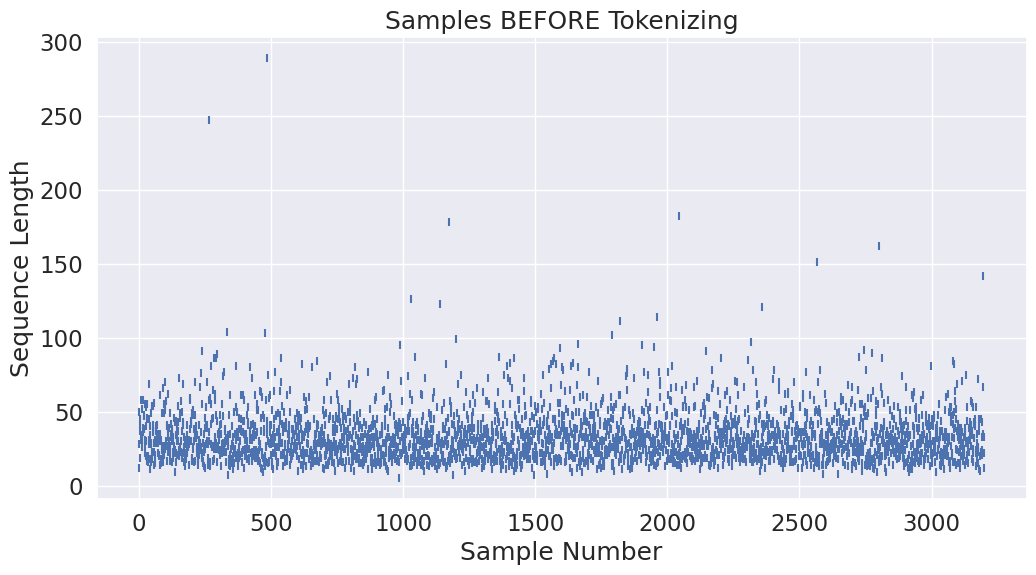

In [46]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [47]:
max_input_length = 300

In [48]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 3,200 training samples...
  Tokenized 0 samples.
  Tokenized 300 samples.
  Tokenized 600 samples.
  Tokenized 900 samples.
  Tokenized 1,200 samples.
  Tokenized 1,500 samples.
  Tokenized 1,800 samples.
  Tokenized 2,100 samples.
  Tokenized 2,400 samples.
  Tokenized 2,700 samples.
  Tokenized 3,000 samples.
DONE.
     3,200 samples


In [49]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

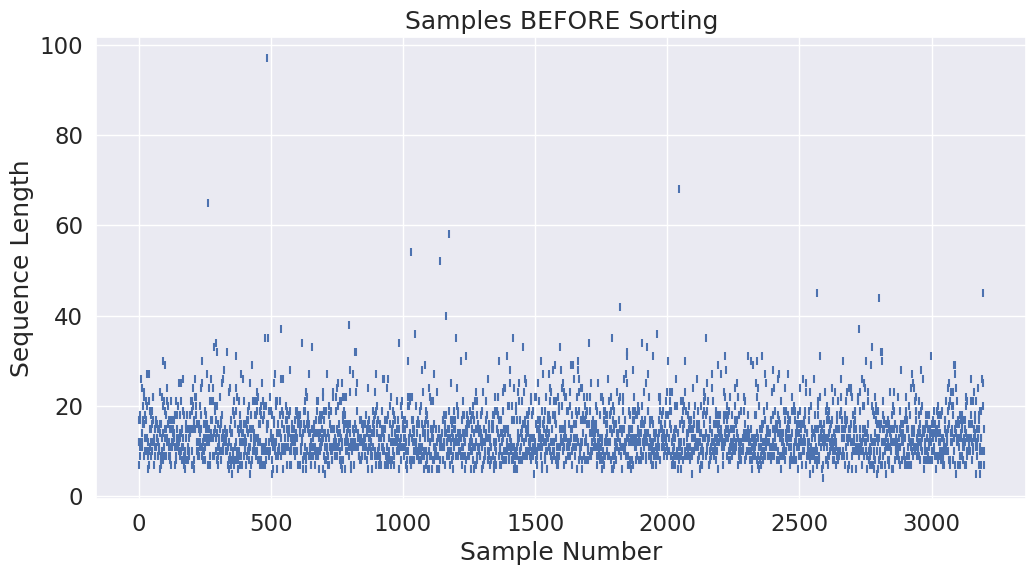

In [50]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [51]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [52]:
train_samples[0:5]

[([0, 127205, 47193, 2], 5),
 ([0, 83526, 9078, 111048, 2], 0),
 ([0, 192262, 63278, 34995, 2], 2),
 ([0, 31527, 223549, 122493, 2], 0),
 ([0, 217092, 180638, 133182, 2], 2)]

In [53]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 4
Longest sample: 97


In [54]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

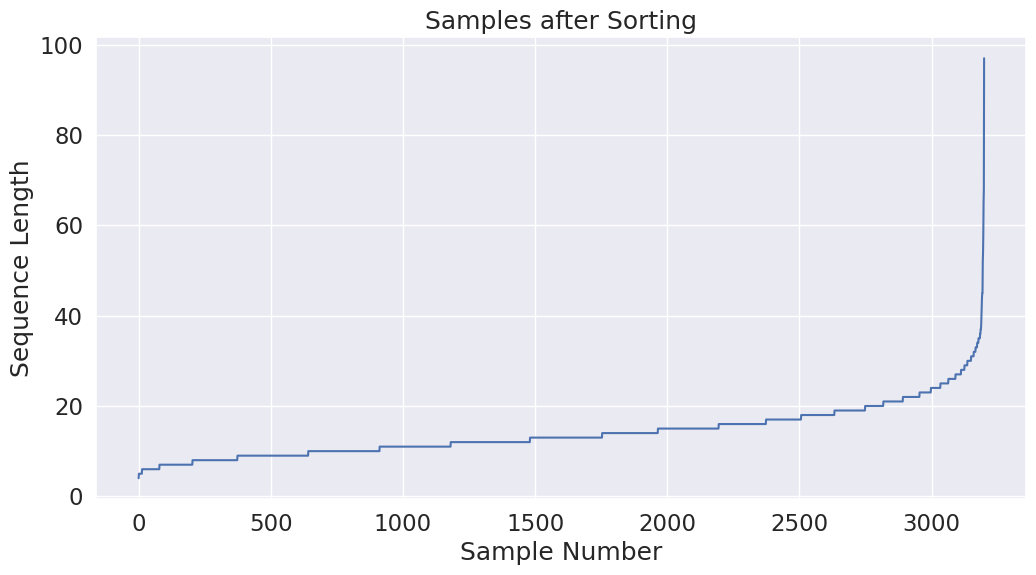

In [55]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [56]:
train_samples[0]

([0, 127205, 47193, 2], 5)

In [57]:
batch_size = 16

In [58]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.

  DONE - 200 batches.


In [59]:
print(batch_ordered_sentences[0])

[[0, 7802, 2784, 37982, 2763, 175377, 5507, 63278, 31056, 36468, 54546, 999, 37982, 3458, 2784, 47886, 207897, 2], [0, 208946, 2730, 35729, 26020, 10567, 9115, 3397, 23456, 91661, 72238, 6155, 6, 167976, 9307, 167397, 125, 2], [0, 91560, 116896, 82712, 956, 2114, 5521, 97903, 41448, 91560, 97903, 47458, 2145, 91560, 97903, 47458, 2145, 2], [0, 85921, 11984, 69634, 2937, 60546, 9618, 14940, 10066, 3718, 125141, 3718, 80181, 896, 102141, 9853, 125141, 2], [0, 6, 61633, 58513, 237924, 7802, 41448, 225507, 5534, 62759, 9755, 90645, 116355, 34545, 40449, 6155, 125, 2], [0, 6, 57158, 2730, 14510, 16209, 8751, 2763, 9681, 35770, 3458, 6, 74670, 88061, 3495, 30414, 15709, 2], [0, 42854, 2730, 20895, 30511, 26596, 36358, 9976, 85181, 180850, 999, 58123, 72238, 15314, 956, 185456, 100461, 2], [0, 18336, 6155, 14767, 9853, 25148, 12814, 4, 22540, 223549, 7802, 26172, 27496, 8050, 44201, 24090, 3718, 2], [0, 81513, 2145, 91560, 44201, 5521, 17145, 20824, 74551, 25792, 17031, 98075, 4091, 29982, 10

In [60]:
batch_ordered_labels[0]

[2, 5, 0, 0, 2, 0, 2, 5, 3, 3, 2, 5, 4, 0, 0, 5]

### Padding

In [61]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [62]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 960,000
  Smart Batching: 46,896  (95.1% less)


## Load the model configuration from the transformers library using AutoConfig

In [63]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.xlm_roberta.configuration_xlm_roberta.XLMRobertaConfig'> 



In [64]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
model.cuda()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

## Load the model from the transformers library using AutoModel

In [66]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.xlm_roberta.modeling_xlm_roberta.XLMRobertaModel'>


In [67]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [68]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [69]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [70]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [71]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [72]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [73]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [74]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        #output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    # (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size,  max_input_length)
    # val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 5 ========
Training on 200 batches...
  Batch      20 of     200. Elapsed: 0:00:05. Remaining: 0:00:49
  Batch      40 of     200. Elapsed: 0:00:08. Remaining: 0:00:32
  Batch      60 of     200. Elapsed: 0:00:11. Remaining: 0:00:25
  Batch      80 of     200. Elapsed: 0:00:13. Remaining: 0:00:20
  Batch     100 of     200. Elapsed: 0:00:16. Remaining: 0:00:16
  Batch     120 of     200. Elapsed: 0:00:19. Remaining: 0:00:13
  Batch     140 of     200. Elapsed: 0:00:21. Remaining: 0:00:09
  Batch     160 of     200. Elapsed: 0:00:24. Remaining: 0:00:06
  Batch     180 of     200. Elapsed: 0:00:27. Remaining: 0:00:03
  Average training loss: 1.28
  Training Accuracy: 0.44
  Training epoch took: 0:00:30
Creating Smart Batches from 400 examples with batch size 16...

Tokenizing 400 samples...
  Tokenized 0 samples.
  Tokenized 40 samples.
  Tokenized 80 samples.
  Tokenized 120 samples.
  Tokenized 160 samples.
  Tokenized 200 samples.
  Tokenized 240 samples.
  Tokeniz

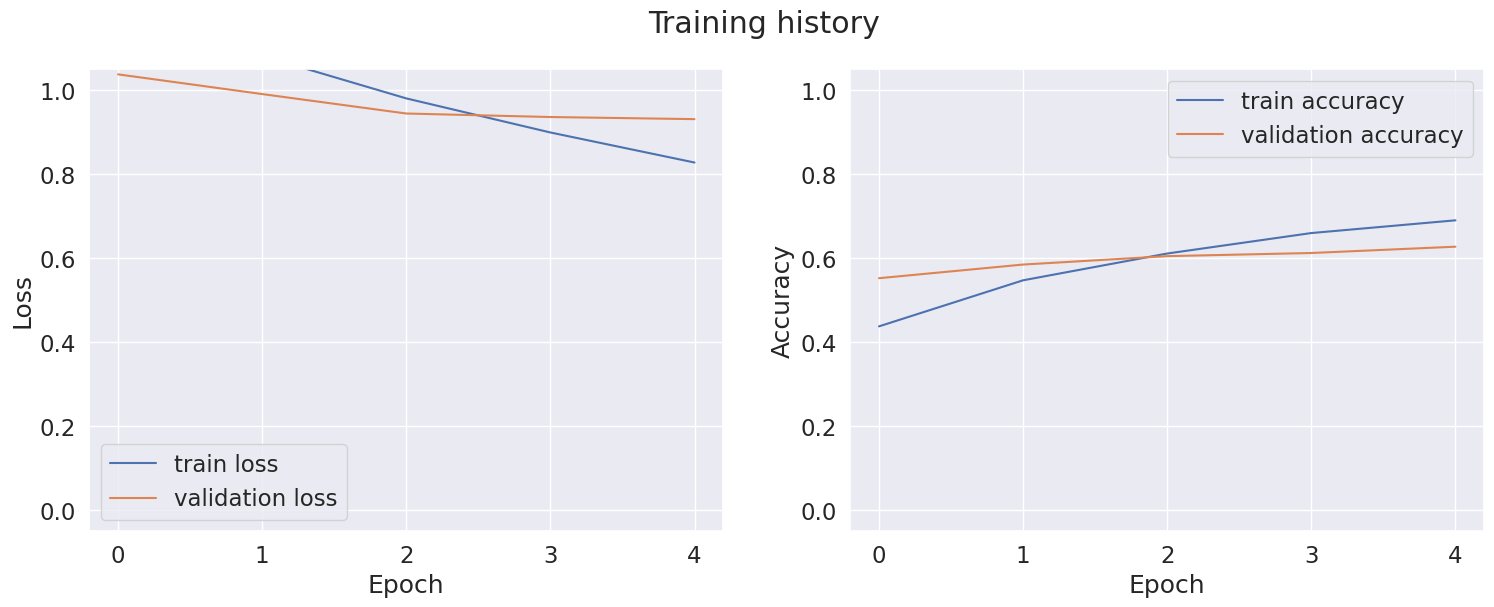

In [75]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [76]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 3,200 examples with batch size 16...

Tokenizing 3,200 samples...
  Tokenized 0 samples.
  Tokenized 300 samples.
  Tokenized 600 samples.
  Tokenized 900 samples.
  Tokenized 1,200 samples.
  Tokenized 1,500 samples.
  Tokenized 1,800 samples.
  Tokenized 2,100 samples.
  Tokenized 2,400 samples.
  Tokenized 2,700 samples.
  Tokenized 3,000 samples.
DONE.
     3,200 samples

     3,200 samples after sorting

Creating batches of size 16...

  DONE - Selected 200 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 200 test batches...
  Batch      20  of      200.    Elapsed: 0:00:00.  Remaining: 0:00:03
  Batch      40  of      200.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      60  of      200.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      80  of      200.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch     100  of      200.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch     120  of      200.    Elapsed: 0:00:

In [77]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.77      0.74      0.75      1298
     Religious_Hatred       0.00      0.00      0.00        20
Gender_Discrimination       0.80      0.91      0.85       497
              Sarcasm       0.00      0.00      0.00        63
            Political       0.70      0.63      0.67       178
               Racism       0.70      0.76      0.73      1144

             accuracy                           0.75      3200
            macro avg       0.50      0.51      0.50      3200
         weighted avg       0.73      0.75      0.74      3200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


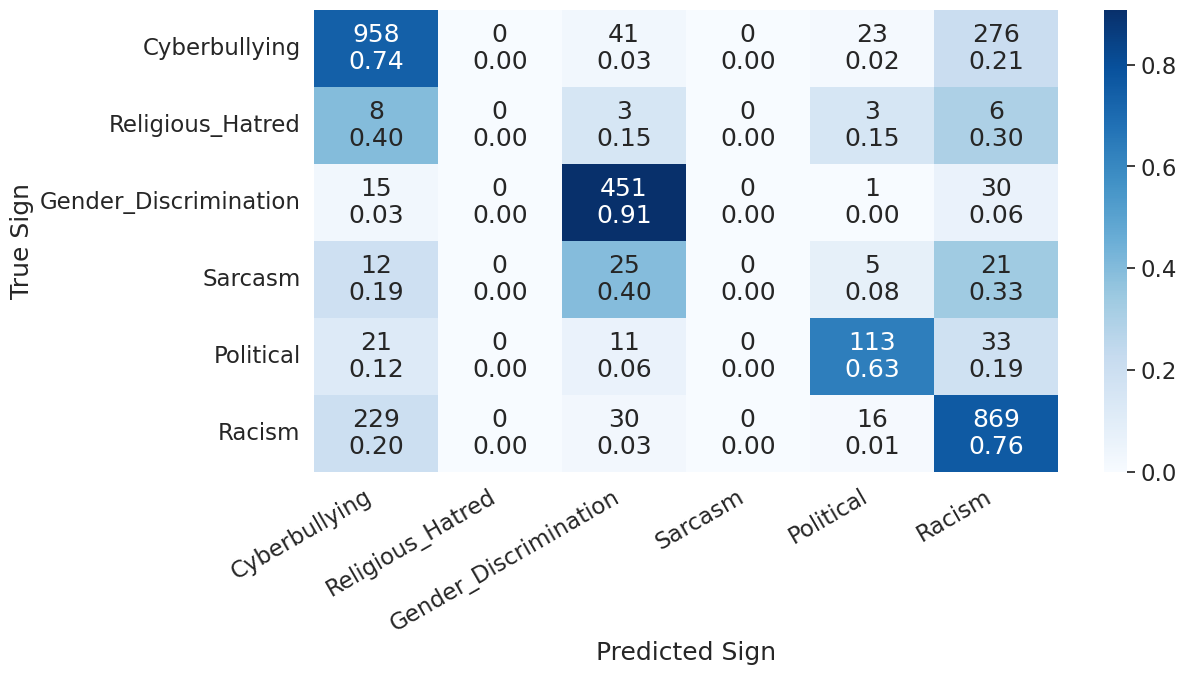

In [78]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [79]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 400 examples with batch size 16...

Tokenizing 400 samples...
  Tokenized 0 samples.
  Tokenized 40 samples.
  Tokenized 80 samples.
  Tokenized 120 samples.
  Tokenized 160 samples.
  Tokenized 200 samples.
  Tokenized 240 samples.
  Tokenized 280 samples.
  Tokenized 320 samples.
  Tokenized 360 samples.
DONE.
       400 samples

       400 samples after sorting

Creating batches of size 16...

  DONE - Selected 25 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 25 test batches...
  Batch       2  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       4  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       6  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      10  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      14  of    

In [80]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.67      0.61      0.64       176
     Religious_Hatred       0.00      0.00      0.00         3
Gender_Discrimination       0.74      0.84      0.79        57
              Sarcasm       0.00      0.00      0.00         8
            Political       0.50      0.47      0.48        17
               Racism       0.55      0.63      0.59       139

             accuracy                           0.63       400
            macro avg       0.41      0.43      0.42       400
         weighted avg       0.61      0.63      0.62       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


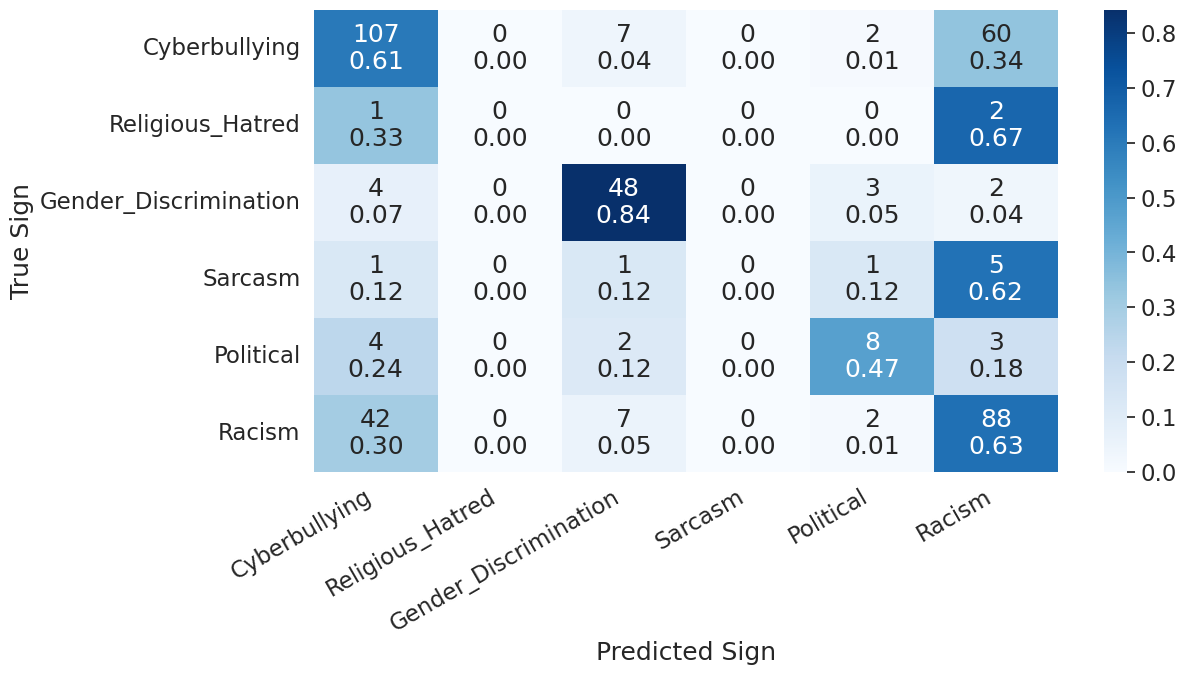

In [81]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [82]:
test_df

,PID,texts,labels
1987,1988,খেলা দুলা করার মতো কেউ নেই,Sarcasm
2893,2894,সেফুদার শিষ্য মনে হচ্ছে,Sarcasm
1860,1861,সালাদের মাথার চুল হুদাই পাকছে,Cyberbullying
3829,3830,সব কথা বের হচ্ছে,Sarcasm
240,241,"ওনার কোনো লজ্জা নেই, ওনি ওনার পদ ছাড়বে না, যতো...",Political
...,...,...,...
3238,3239,কাউয়া কা কা ছাড়া পারে কি,Sarcasm
33,34,অবৈধ স্বৈরাচার সরকারের বিরুদ্ধে আন্দোলন গড়ে ত...,Political
486,487,আমি ত বউ এর মাথা খুজে পাচ্ছিলাম না,Sarcasm
69,70,"গান গায় জেফার,,,শ্বাসকষ্ট হয় আমাদের.",Sarcasm


## Loading `test_sentences`

In [83]:
test_sentences = test_df['texts'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [84]:
test_ids

array([1987, 2893, 1860, 3829,  240, 1178, 2483, 3609,  184, 3936,   80,
       3493,  463, 2592, 2176, 3786, 3751, 3265, 1583, 1237, 2618, 1807,
       3484, 3536,  102,  346, 3518,  387, 1055, 3927, 1402, 1572, 2476,
        134, 1795, 1114,  544, 1429, 1315, 2216, 3237,  321, 3544, 3288,
        325,  432, 2350, 1146, 2240, 2567, 2014, 1510,  205, 2754, 1117,
       2456, 1563,  751, 1653, 2211, 1138,  893, 1873, 2325, 3058, 1744,
        309, 2684, 1476, 1200, 2585, 1621, 3804,  461, 2428, 1461, 1411,
       1684, 2121, 2403,  471, 3867,   44, 3440, 2716,  969, 1345, 3024,
       3173, 2119, 3549, 2053, 2276, 1973, 1992, 2452,  220, 2530, 2907,
       1995, 1278, 2969,  178,   30,   70, 1513, 3596,  430, 3497, 1840,
        495, 1185, 3517,  109, 3032, 1061, 3870, 2722, 3953, 2758, 3887,
        152,   45, 2784, 1052, 1978, 3600, 1728, 1964, 1675, 1659, 3432,
       1330, 1233, 1536,  308, 1488, 2067, 2828, 2358, 2803,  270,  192,
       3882, 3201, 1952, 3644,  274,  166, 1450, 17

In [85]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 400 examples with batch size 16...

Tokenizing 400 samples...
  Tokenized 0 samples.
  Tokenized 40 samples.
  Tokenized 80 samples.
  Tokenized 120 samples.
  Tokenized 160 samples.
  Tokenized 200 samples.
  Tokenized 240 samples.
  Tokenized 280 samples.
  Tokenized 320 samples.
  Tokenized 360 samples.
DONE.
       400 samples

       400 samples after sorting

Creating batches of size 16...

  DONE - Selected 25 batches.

Padding out sequences within each batch...
  DONE.


In [86]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 25 test batches...
  Batch       2  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       4  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       6  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      10  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      14  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      18  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      22  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00


In [87]:
test_sentences

array(['খেলা দুলা করার মতো কেউ নেই', 'সেফুদার শিষ্য মনে হচ্ছে',
       'সালাদের মাথার চুল হুদাই পাকছে', 'সব কথা বের হচ্ছে',
       'ওনার কোনো লজ্জা নেই, ওনি ওনার পদ ছাড়বে না, যতো বাঁচবে',
       'ইন্নাদ্দ্বীনা ইনদাল্লাহিল ইসলাম',
       'এদের মতন সুবিধাবাদী দালাল কিভাবে তরুণদের আইডল হয়।',
       'বিডিও কল হয় নি বুঝছি',
       'আফগানিস্তান জিন্দাবাদ। বাংলাদেশ ক্রিকেট টিম মুর্দাবাদ।',
       'হেতিরে কেউ একজন আসি বাথরুমের ব্রাশ দিয়ে দাঁতগুলো মাজি দাও ',
       'এম্নে চ্যাগাইয়া না বসলে কি ফটোগ্রাফার পিক টা তুলতে পারতেছিল না!',
       'দোরো শালার ছাও', 'মেহেদি ভাই ভাবি কি খেপছে',
       'স্মার্ট বাংলাদেশের বর্বরতার প্রতিচ্ছবি',
       'কি বাল টাই না ফালাইলাম জীবনে',
       'কই এতদিন তো বলতে দেখলাম না এগুলা আগে বলার দরকার ছিল',
       'হাছিনাকে পয়দা করা....', 'কেন্দে দিয়েছে',
       'হালার ভাই হালারা নাটক চোদাও', 'তোকে চিরিয়াখায়ান রাখলে ভালো হবে',
       'সাধারণ শিক্ষার্থীদের কান্না', 'ঠিক জায়গায় বাঁশ টা দিছে ভয়রা',
       'আরও গোছাতে হবে।', 'পৃথিবীতে এত ট্যালেন্টেড মানুষ আছে ভাবা যায়',
 

In [88]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 400 examples with batch size 16...

Tokenizing 400 samples...
  Tokenized 0 samples.
  Tokenized 40 samples.
  Tokenized 80 samples.
  Tokenized 120 samples.
  Tokenized 160 samples.
  Tokenized 200 samples.
  Tokenized 240 samples.
  Tokenized 280 samples.
  Tokenized 320 samples.
  Tokenized 360 samples.
DONE.
       400 samples

       400 samples after sorting

Creating batches of size 16...

  DONE - Selected 25 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 25 test batches...
  Batch       2  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       4  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       6  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      10  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      14  of    

In [89]:
y_pred

array([2, 5, 5, 5, 4, 5, 5, 5, 5, 4, 0, 5, 0, 0, 0, 5, 5, 0, 0, 0, 0, 2,
       5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 5, 0, 2, 0, 0, 0, 2,
       4, 5, 2, 5, 0, 5, 0, 5, 0, 0, 5, 5, 0, 2, 5, 0, 5, 0, 5, 5, 5, 2,
       5, 2, 0, 5, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 2, 5, 0, 4, 5, 0, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 0, 2, 5, 5, 5, 0, 5, 0, 0, 0, 5, 5, 5, 2, 5,
       0, 2, 2, 4, 5, 2, 0, 5, 5, 0, 5, 2, 0, 0, 0, 5, 5, 5, 0, 5, 0, 2,
       5, 5, 2, 0, 2, 5, 5, 2, 0, 0, 2, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 2,
       0, 5, 5, 5, 5, 5, 2, 5, 0, 0, 5, 2, 0, 2, 2, 2, 0, 5, 2, 2, 5, 0,
       5, 0, 2, 0, 5, 0, 5, 5, 5, 2, 5, 0, 5, 0, 5, 5, 5, 0, 5, 2, 5, 0,
       5, 5, 5, 0, 0, 5, 0, 0, 0, 5, 0, 5, 0, 2, 0, 5, 5, 0, 5, 2, 0, 0,
       0, 0, 2, 2, 0, 0, 5, 0, 4, 5, 0, 0, 0, 0, 2, 5, 0, 0, 2, 2, 0, 2,
       5, 0, 4, 5, 0, 4, 0, 0, 0, 2, 5, 0, 5, 0, 0, 5, 0, 5, 2, 0, 0, 5,
       5, 2, 2, 0, 0, 0, 5, 0, 0, 2, 4, 0, 5, 0, 0, 2, 0, 5, 0, 0, 0, 5,
       0, 0, 2, 0, 0, 5, 2, 0, 5, 4, 0, 0, 0, 5, 2,

## Evaluating accuracy over test set

In [90]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 25 test batches...
  Batch       2  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       4  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       6  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch       8  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      10  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      12  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      14  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      16  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      18  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      20  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      22  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      24  of       25.    Elapsed: 0:00:00.  Remaining: 0:00:00


In [91]:
print(y_preds)

[2 5 5 5 4 5 5 5 5 4 0 5 0 0 0 5 5 0 0 0 0 2 5 5 5 5 0 5 5 5 5 5 0 5 0 0 0
 5 0 2 0 0 0 2 4 5 2 5 0 5 0 5 0 0 5 5 0 2 5 0 5 0 5 5 5 2 5 2 0 5 0 5 5 0
 5 5 5 5 5 5 2 5 0 4 5 0 5 5 5 5 5 5 5 5 0 0 2 5 5 5 0 5 0 0 0 5 5 5 2 5 0
 2 2 4 5 2 0 5 5 0 5 2 0 0 0 5 5 5 0 5 0 2 5 5 2 0 2 5 5 2 0 0 2 0 5 5 5 5
 5 5 0 0 5 2 0 5 5 5 5 5 2 5 0 0 5 2 0 2 2 2 0 5 2 2 5 0 5 0 2 0 5 0 5 5 5
 2 5 0 5 0 5 5 5 0 5 2 5 0 5 5 5 0 0 5 0 0 0 5 0 5 0 2 0 5 5 0 5 2 0 0 0 0
 2 2 0 0 5 0 4 5 0 0 0 0 2 5 0 0 2 2 0 2 5 0 4 5 0 4 0 0 0 2 5 0 5 0 0 5 0
 5 2 0 0 5 5 2 2 0 0 0 5 0 0 2 4 0 5 0 0 2 0 5 0 0 0 5 0 0 2 0 0 5 2 0 5 4
 0 0 0 5 2 0 5 5 0 2 2 5 2 5 5 0 2 5 5 0 0 0 5 0 5 0 0 5 5 5 2 2 2 2 5 0 0
 2 2 0 4 0 0 2 0 0 5 5 0 0 0 0 2 4 5 0 0 0 5 0 5 4 2 5 0 2 0 0 2 0 2 2 5 5
 5 5 5 0 4 5 0 5 0 2 2 0 5 5 5 5 5 0 0 0 0 0 0 5 0 0 0 0 0 5]


In [92]:
print(y_ids)

[2988 2702 2424 2893 2240 1621 1461 1411 3440  969 1964 3432 1233 2473
 1023 2003 1987 3493 2350 1146 1510 2585 2428  471 1345 1973 1513 1675
 1659 2358 3331 1740  240   30 2722 1556 2603 1315  109 3931  838  776
 3936 3997 3402   88 1330  308  194 3940  387 1795 2216 3237 1052 2067
 2828 3201 3644 1909  410 1721 3802  798 2404  718  842 3416 2272  864
 1517 3238 3609 1114  544  751 2211 2119 2907  430 3032 1822 3594  923
  862 2463 2319 3684 2024  144 3484 1055  134 1563 1138 1200 3024 1840
 2758  332  299 2499  812  415 1764 2487  179  599 3846 1532 2979 2682
 1272 1178  463 2592 1583 1237 1807 1402 3544 2567 1653 1684 3953  152
 2784 1450  205 2754  321  893 3058  461   44 3173 3879 2375 2392 2627
  314 1393 1293 1670 2276 1992 3596 3804 3549 3504 1878 1877 2562 3838
 1022 2973 3456 3857 1075 2359 2866 1945  978 3299 2023 3873 2732 1292
 2894 1552 3248 2847 3317 2233  511 2770  869 2009 3799 1041 1736 1691
 2873   23  438 3431 3579 1044 2212 2882 3491 3693 2250  990 2801  888
 2989 

In [93]:
le.inverse_transform(y_preds)

array(['Political', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Religious_Hatred',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Religious_Hatred',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Sarcasm', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Cyberbullying',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Political',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Religious_Hatred', 'Sarcasm', 'Political', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Political', 'Sarcasm', 'Cyberbullying',
       'Sarcasm', 'Cyberbullying', 'Sarcasm', 'Sarcasm', 'Sarcasm

<Axes: xlabel='count'>

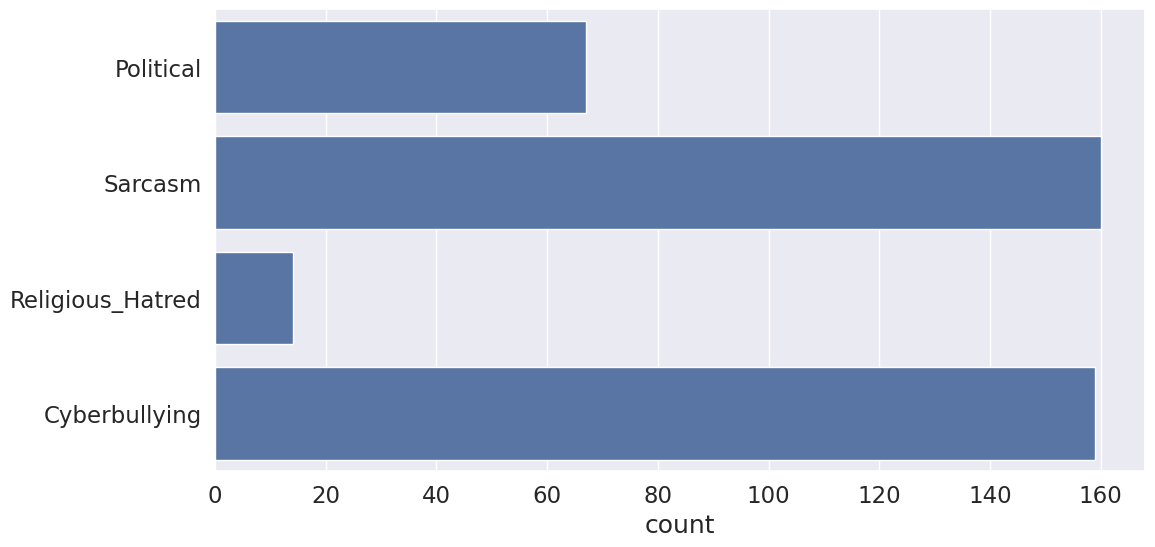

In [94]:
sns.countplot(y =le.inverse_transform(y_preds))

In [96]:
len(y_ids)

400

In [97]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['Political', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Religious_Hatred',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Religious_Hatred',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Sarcasm', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Cyberbullying',
       'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Political',
       'Cyberbullying', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Religious_Hatred', 'Sarcasm', 'Political', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Cyberbullying', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Sarcasm', 'Sarcasm',
       'Cyberbullying', 'Political', 'Sarcasm', 'Cyberbullying',
       'Sarcasm', 'Cyberbullying', 'Sarcasm', 'Sarcasm', 'Sarcasm